In [3]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
def load_hyperparameter_runs_as_dict(base_folder: str):
    """
    Durchsucht den angegebenen base_folder nach allen Unterordnern, die mit 'train_hyper_' beginnen.
    Für jeden gefundenen Ordner werden folgende Dateien eingelesen:
      - params.json
      - progress.csv
      - result.json (kann mehrere JSON-Zeilen beinhalten)
      
    Anschließend wird ein Dictionary erstellt, dessen Keys von 0 bis n-1 durchnummeriert sind.
    
    Struktur pro Eintrag:
      {
        "id": <Ordnername oder Modell-ID für die Identifikation>,
        
        # aus params.json
        "learning_rate": float,
        "batch_size": int,
        "auto_cast": bool,
        "max_epochs": int,
        "weight_decay": float,
        
        # result.json (Liste mehrerer Dictionaries, pro Zeile eine)
        "result": [
          { ... },
          { ... },
          ...
        ],
        
        # progress.csv (Liste mehrerer Dictionaries, pro Zeile eine)
        "progress": [
          { "loss": ..., "val_loss": ..., ... },
          ...
        ]
      }
    """
    # Dictionary, das wir befüllen
    runs_data = {}
    
    # Alle train_hyper_-Ordner ermitteln
    train_folders = [
        f
        for f in os.listdir(base_folder)
        if f.startswith("train_hyper_") and os.path.isdir(os.path.join(base_folder, f))
    ]
    
    # Sortieren nach Ordnernamen, damit wir eine definierte Reihenfolge haben
    train_folders.sort()
    
    # Durch alle train_hyper_*-Ordner iterieren
    for i, folder_name in enumerate(train_folders):
        folder_path = os.path.join(base_folder, folder_name)
        
        # Pfade zu den Dateien
        params_file   = os.path.join(folder_path, "params.json")
        progress_file = os.path.join(folder_path, "progress.csv")
        result_file   = os.path.join(folder_path, "result.json")
        
        # Existenzcheck
        if not (
            os.path.isfile(params_file)
            and os.path.isfile(progress_file)
            and os.path.isfile(result_file)
        ):
            # Überspringen, wenn eine der Dateien fehlt
            continue
        
        # 1) params.json einlesen
        with open(params_file, "r", encoding="utf-8") as f:
            params_dict = json.load(f)
        
        # 2) progress.csv einlesen
        progress_df = pd.read_csv(progress_file)
        # Als Liste von Dictionaries (jede Zeile → 1 Dict) exportieren
        progress_records = progress_df.to_dict(orient="records")
        
        # 3) result.json einlesen (mehrere Zeilen JSON)
        result_records = []
        with open(result_file, "r", encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if line:
                    result_records.append(json.loads(line))
        
        # 4) Dictionary für diesen Lauf bauen
        run_dict = {}
        
        # - (a) "id" für die Identifikation (z. B. ganzer Ordnername)
        run_dict["id"] = folder_name
        
        # - (b) Alle Keys aus params.json übernehmen
        for k, v in params_dict.items():
            run_dict[k] = v
        
        # - (c) 'result' → Liste der Datensätze aus result.json
        run_dict["result"] = result_records
        
        # - (d) 'progress' → Liste der Datensätze aus progress.csv
        run_dict["progress"] = progress_records
        
        # 5) Speichere run_dict im großen Dictionary runs_data
        runs_data[i] = run_dict
    
    return runs_data


In [5]:
base_log_dir = "HyperparameterLOG/lraspp_mobilenet_v3_large/Hyperparameter_Tuning_Deeplabv3"
    

In [6]:
df_all = load_hyperparameter_runs_as_dict(base_log_dir)

In [7]:
print(df_all.keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])


In [8]:
print(df_all[0].keys())

print(df_all[0]["result"][0]["trial_id"])

dict_keys(['id', 'auto_cast', 'batch_size', 'learning_rate', 'max_epochs', 'weight_decay', 'result', 'progress'])
04296c2d


In [9]:
#for i in range(50):
i = 1

print(df_all[i]['id'])  
print(df_all[i]['auto_cast'])
print(df_all[i]['batch_size'])
print(df_all[i]['learning_rate'])
print(df_all[i]['result'][0])

train_hyper_073d30e9_40_auto_cast=False,batch_size=16,learning_rate=0.0021,max_epochs=100,weight_decay=0.0000_2025-01-20_02-56-01
False
16
0.0020610788976552358
{'loss': 0.8673887655889387, 'val_loss': 1.022340192113604, 'train_acc': 75.30827281591887, 'val_acc': 68.59462467008642, 'timestamp': 1737338577, 'checkpoint_dir_name': 'checkpoint_000000', 'should_checkpoint': True, 'done': False, 'training_iteration': 1, 'trial_id': '073d30e9', 'date': '2025-01-20_03-02-57', 'time_this_iter_s': 85.88374948501587, 'time_total_s': 85.88374948501587, 'pid': 619031, 'hostname': 'jan-desktop', 'node_ip': '10.7.0.4', 'config': {'learning_rate': 0.0020610788976552358, 'batch_size': 16, 'weight_decay': 3.570446505901037e-06, 'auto_cast': False, 'max_epochs': 100}, 'time_since_restore': 85.88374948501587, 'iterations_since_restore': 1}


In [10]:
def plot_validation_accuracy(data_dict):
    """
    Plottet die Validation Accuracy (val_acc) aller Modelle über ihre Training-Iteration.
    
    - Die "Top-3" Modelle (basierend auf maximal erreichter val_acc) werden farbig,
      dicker und oben (zorder) gezeichnet.
    - Alle anderen Modelle werden grau gezeichnet.
    - Die Model-ID wird aus data_dict[i]["result"][0]["trial_id"] gelesen.
    """
    
    # 1) Bestimme den Score der Modelle anhand ihres maximalen val_acc
    model_scores = []
    for i, model_data in data_dict.items():
        progress_list = model_data.get("progress", [])
        if not progress_list:
            # kein progress -> score 0
            max_val_acc = 0
        else:
            val_accs = [row.get("val_acc", 0) for row in progress_list]
            max_val_acc = max(val_accs) if val_accs else 0
        
        model_scores.append((i, max_val_acc))
    
    # Sortiere Modelle nach max_val_acc (absteigend)
    model_scores.sort(key=lambda x: x[1], reverse=True)
    
    # Index der Top-3 herausfiltern
    top_3_indices = [score[0] for score in model_scores[:3]]
    
    # 2) Farben für Top-3 (kannst du beliebig anpassen)
    colors_top = ['C1', 'C2', 'C3']  # Standard-Farben in matplotlib
    color_others = 'gray'
    
    plt.figure(figsize=(10, 6))
    
    # 3) Alle Modelle plotten
    for i, model_data in data_dict.items():
        progress_list = model_data.get("progress", [])
        if not progress_list:
            continue
        
        # X- und Y-Werte
        x_vals = [row.get("training_iteration", idx+1) for idx, row in enumerate(progress_list)]
        y_vals = [row.get("val_acc", 0) for row in progress_list]
        
        # Letzte Accuracy (für die Beschriftung der Top-3)
        final_val_acc = y_vals[-1] if len(y_vals) > 0 else 0
        
        # Lese die Modell-ID direkt aus result[0]["trial_id"]
        if "result" in model_data and len(model_data["result"]) > 0:
            model_id = model_data["result"][0].get("trial_id", f"Model_{i}")
        else:
            model_id = f"Model_{i}"
        
        # Prüfen, ob Modell in Top-3
        if i in top_3_indices:
            # Top-3: spezielle Farbe + Label
            top_index = top_3_indices.index(i)  # 0, 1, oder 2
            c = colors_top[top_index]
            
            label = f"{model_id} (letzte acc={final_val_acc:.2f}%)"
            
            # Mit hohem zorder und dicker Linie
            plt.plot(
                x_vals, y_vals,
                color=c,
                linewidth=1.5,
                alpha=1.0,
                zorder=10,
                label=label
            )
        else:
            # Andere Modelle in Grau, dünner, ohne Label
            plt.plot(
                x_vals, y_vals,
                color=color_others,
                linewidth=1.0,
                alpha=0.4,
                zorder=1
            )
    
    # 4) Achsenbeschriftung, Titel und Legende
    plt.title("Validation Accuracy aller Modelle")
    plt.xlabel("Training Iteration")
    plt.ylabel("Validation Accuracy (%)")
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Falls du prozentuale Werte hast, kann die y-Achse auf 0..100
    plt.ylim(0, 100)
    
    # Nur Top-3 haben ein Label, daher wird nur hierfür eine Legende angezeigt
    plt.legend()
    
    plt.show()


# Beispiel-Aufruf in Jupyter:
# data_dict = load_hyperparameter_runs_as_dict(base_log_dir)
# plot_validation_accuracy(data_dict)


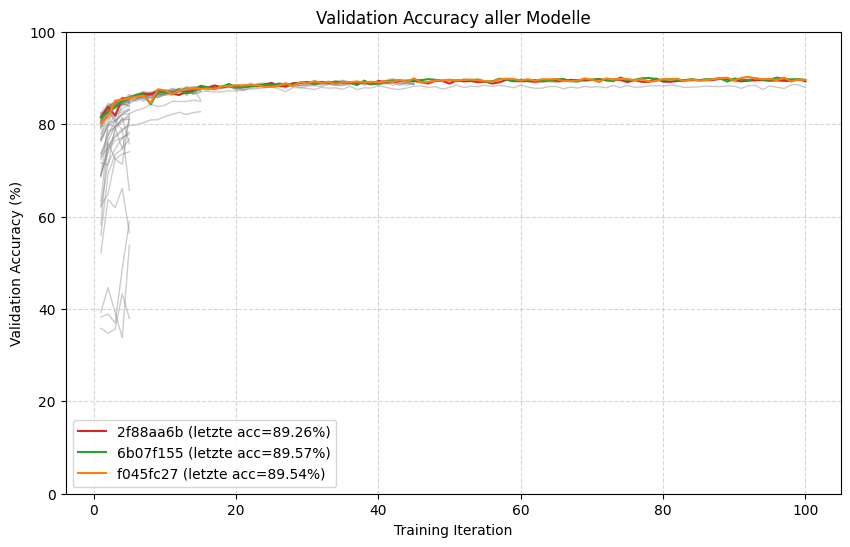

In [11]:
plot_validation_accuracy(df_all)

In [12]:
import matplotlib.pyplot as plt

def plot_validation_accuracy_ended_early(data_dict):
    """
    Plots the validation accuracy (val_acc) for each model over its training iteration.
    - All models have gray lines.
    - Models with fewer than 100 training iterations get a red line (ended early).
    """

    plt.figure(figsize=(10, 6))

    # Colors
    color_completed = 'gray'
    color_ended_early = 'red'

    # Legend labels
    label_completed = "Completed (>= 100 iterations)"
    label_ended_early = "Ended Early (< 100 iterations)"

    # To avoid repeating the same legend entry for multiple lines,
    # we keep track of whether we have already plotted each label.
    plotted_completed_label = False
    plotted_ended_label = False

    for i, model_data in data_dict.items():
        progress_list = model_data.get("progress", [])
        if not progress_list:
            # Skip models with no progress entries
            continue

        # Extract x/y data
        x_vals = [row.get("training_iteration", idx+1) for idx, row in enumerate(progress_list)]
        y_vals = [row.get("val_acc", 0) for row in progress_list]

        # Check if this model ended early (fewer than 100 iterations)
        if len(progress_list) < 100:
            # Ended early
            plot_color = color_ended_early
            if not plotted_ended_label:
                plt.plot(x_vals, y_vals, color=plot_color, linewidth=1.0,
                         alpha=0.8, label=label_ended_early)
                plotted_ended_label = True
            else:
                plt.plot(x_vals, y_vals, color=plot_color, linewidth=1.0,
                         alpha=0.8)
        else:
            # Completed (at least 100 iterations)
            plot_color = color_completed
            if not plotted_completed_label:
                plt.plot(x_vals, y_vals, color=plot_color, linewidth=2.0,
                         alpha=0.8, label=label_completed)
                plotted_completed_label = True
            else:
                plt.plot(x_vals, y_vals, color=plot_color, linewidth=2.0,
                         alpha=0.8)

    # Aesthetics
    plt.title("Validation Accuracy (Early End vs. Completed)")
    plt.xlabel("Training Iteration")
    plt.ylabel("Validation Accuracy")
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # If your accuracies range 0..100 (percent), use:
    plt.ylim([0, 100])
    
    # Show legend
    plt.legend()
    plt.show()


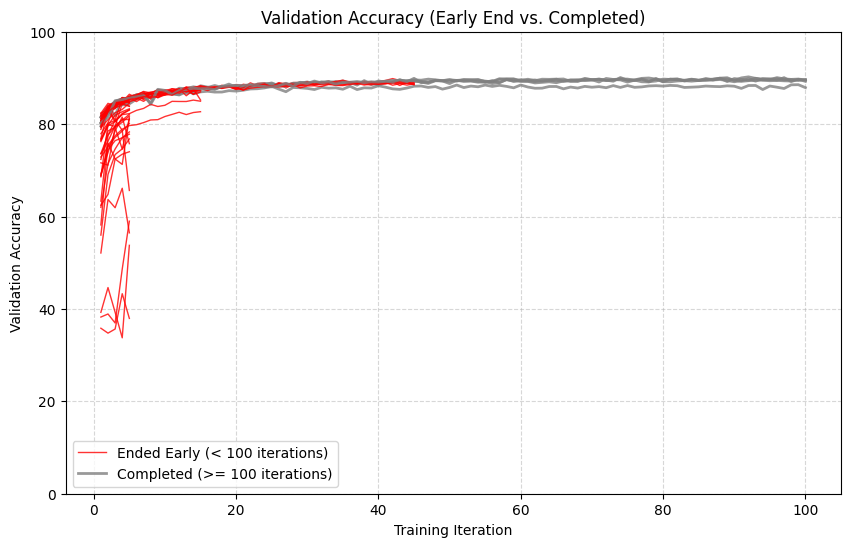

In [13]:
plot_validation_accuracy_ended_early(df_all)

In [16]:
import matplotlib.pyplot as plt

def plot_top_3_models_side_by_side(data_dict):
    """
    1) Identify the top 3 models by their maximum validation accuracy (val_acc).
    2) Create a single figure with 3 subplots (1 row, 3 columns).
       Each subplot corresponds to one model and shows:
         - Training Loss (on left y-axis)
         - Validation Loss (on left y-axis)
         - Training Accuracy (on right y-axis)
         - Validation Accuracy (on right y-axis)
    """

    # --------------------------------------------------------
    # STEP 1: Find the top-3 models by max val_acc
    # --------------------------------------------------------
    model_scores = []
    for i, model_data in data_dict.items():
        progress_list = model_data.get("progress", [])
        if not progress_list:
            # No progress → treat val_acc as 0
            max_val_acc = 0
        else:
            val_accs = [row.get("val_acc", 0) for row in progress_list]
            max_val_acc = max(val_accs) if val_accs else 0

        model_scores.append((i, max_val_acc))

    # Sort by max_val_acc descending
    model_scores.sort(key=lambda x: x[1], reverse=True)

    # Get the top-3
    top_3 = model_scores[:3]

    # If there are fewer than 3 models, adjust accordingly
    if len(top_3) == 0:
        print("No models found with progress data.")
        return

    # --------------------------------------------------------
    # STEP 2: Create one figure with 3 subplots (side by side)
    # --------------------------------------------------------
    # If you have fewer than 3 models total, you'd do min(3, len(top_3)) as columns
    #fig, axes = plt.subplots(1, len(top_3), figsize=(18, 6), sharex=False)
    fig, axes = plt.subplots(len(top_3), 1, figsize=(8, 18), sharex=False)


    # If there's only 1 or 2 top models, axes might not be iterable. Make it so:
    if len(top_3) == 1:
        axes = [axes]  # single subplot
    elif len(top_3) == 2:
        axes = list(axes)

    for col, (model_index, _) in enumerate(top_3):
        model_data = data_dict[model_index]
        progress_list = model_data.get("progress", [])
        if not progress_list:
            continue

        # Extract x and y data
        x_vals       = [row.get("training_iteration", idx+1) for idx, row in enumerate(progress_list)]
        train_loss   = [row.get("loss", 0)      for row in progress_list]
        val_loss     = [row.get("val_loss", 0)  for row in progress_list]
        train_acc    = [row.get("train_acc", 0) for row in progress_list]
        val_acc      = [row.get("val_acc", 0)   for row in progress_list]

        # Optionally, get a model ID from result[0]["trial_id"] or from "id"
        if "result" in model_data and len(model_data["result"]) > 0:
            model_id = model_data["result"][0].get("trial_id", f"Model {model_index}")
        else:
            model_id = model_data.get("id", f"Model {model_index}")

        # Current subplot (axes[col])
        ax_loss = axes[col]              # Left y-axis for Loss
        ax_acc = ax_loss.twinx()         # Right y-axis for Accuracy

        # Plot Losses (left axis)
        ln1 = ax_loss.plot(
            x_vals, train_loss,
            color='blue', linewidth=2, label='Train Loss'
        )
        ln2 = ax_loss.plot(
            x_vals, val_loss,
            color='orange', linewidth=2, linestyle='-', label='Val Loss'
        )

        # Plot Accuracies (right axis)
        ln3 = ax_acc.plot(
            x_vals, train_acc,
            color='green', linewidth=2, label='Train Acc'
        )
        ln4 = ax_acc.plot(
            x_vals, val_acc,
            color='red', linewidth=2, linestyle='-', label='Val Acc'
        )

        # Titles, labels, etc.
        ax_loss.set_title(f"Model {model_index}: {model_id}", fontsize=13)
        ax_loss.set_xlabel("Iteration")
        ax_loss.set_ylabel("Loss")
        ax_acc.set_ylabel("Accuracy (%)")

        # If you store accuracy in [0..1] range, change this:
        ax_acc.set_ylim(0, 100)

        ax_loss.grid(True, linestyle='-', alpha=0.5)

        # Combine legend from both axes
        lines = ln1 + ln2 + ln3 + ln4
        labels = [l.get_label() for l in lines]
        ax_loss.legend(lines, labels, loc='upper center')

    fig.suptitle("Top-3 Models: Loss & Accuracy in One Plot per Model", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# ----------------------------------------------------
# Example usage in a Jupyter Notebook:
# ----------------------------------------------------
# data_dict = load_hyperparameter_runs_as_dict(base_log_dir)
# plot_top_3_models_side_by_side(data_dict)


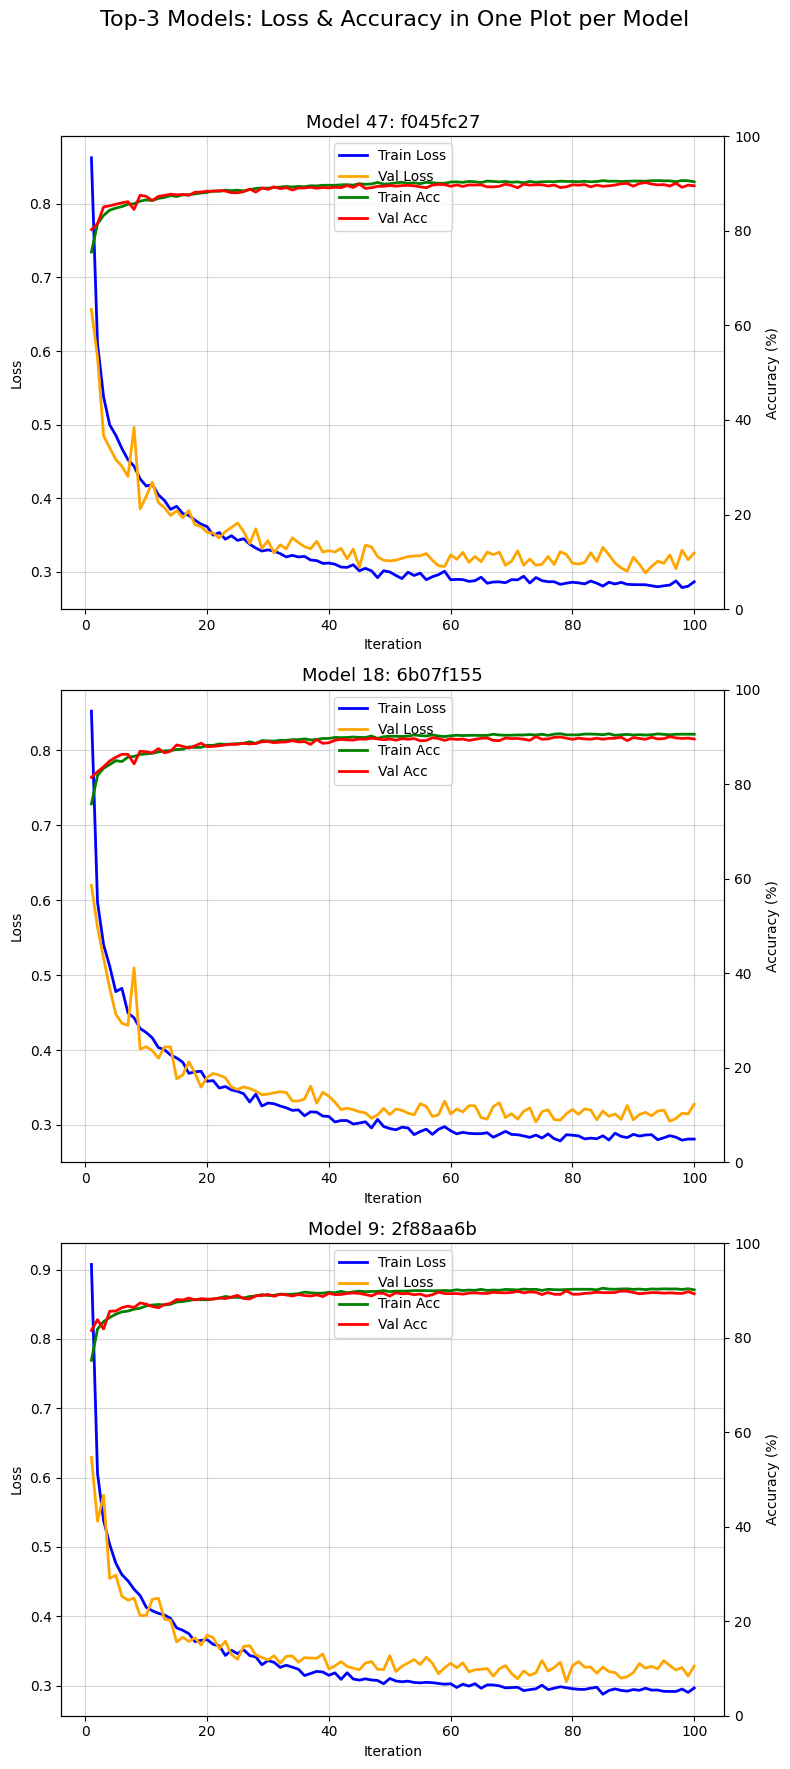

In [17]:
plot_top_3_models_side_by_side(df_all)